**Homework 2 submission by Soumyajyoti Bhattacharya. In this one, the notebook takes data from one of many online available temporal energy consumption datasets of PJM Interconnection which supplies energy to 13 East Coast US States and the District of Columbia**

In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
import seaborn as sns
import datetime
from bokeh.plotting import figure, show, output_notebook
%matplotlib inline

Two dataframes are created here. The first one indexes based on date time so as to use the timestamp as it's temporal indexing factor. On the other hand, the second dataframe is utilized for better understanding and evaluating the data.

In [4]:
df = pd.read_csv('/content/drive/My Drive/hourly-energy-consumption/PJME_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [5]:

df2 = pd.read_csv('/content/drive/My Drive/hourly-energy-consumption/PJME_hourly.csv')
df2.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [6]:
df.isna().sum()

PJME_MW    0
dtype: int64

No "NA" Values signify no need to deal with empty cells or NaN values in the dataframe.

In [0]:
plt.style.use("ggplot")

The below plot uses bokeh to build a nice JS based plot from the data in python showcasing an interactive historgram of the general power consumption

In [8]:
p = figure(title="Consumption Distribution")
hist, edges = np.histogram(df["PJME_MW"], density=True, bins=50)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
output_notebook()
show(p)

The plots below uses pre-defined functions to make a quarterly division in the data based on timestamps and provides us with interesting insights into the data while the one after that gives us a simplified view of cumulative daily consumption

Text(0.5, 1.0, 'Q4 - Consumption')

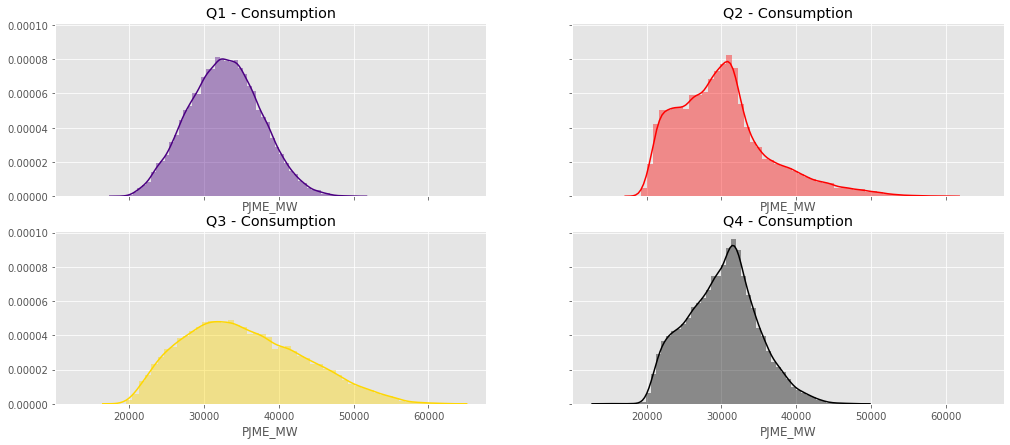

In [9]:
df2["Datetime"] = pd.to_datetime(df2["Datetime"])
df2["Q"] = df2["Datetime"].dt.quarter
Q1 = df2[df2["Q"]==1]
Q2 = df2[df2["Q"]==2]
Q3 = df2[df2["Q"]==3]
Q4 = df2[df2["Q"]==4]

fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["PJME_MW"],color="indigo", ax=axes[0,0]).set_title("Q1 - Consumption")
sns.distplot(Q2["PJME_MW"],color="red", ax=axes[0,1]).set_title("Q2 - Consumption")
sns.distplot(Q3["PJME_MW"],color="gold", ax=axes[1,0]).set_title("Q3 - Consumption")
sns.distplot(Q4["PJME_MW"],color="black", ax=axes[1,1]).set_title("Q4 - Consumption")

Text(0.5, 1.0, 'Cumulative daily consumption')

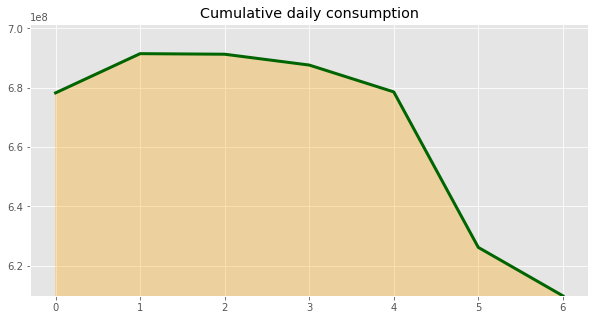

In [10]:
df2["Day"] = df2["Datetime"].dt.dayofweek
sum_per_day = df2.groupby("Day")["PJME_MW"].agg(["sum"])
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(sum_per_day.index, sum_per_day["sum"], color="darkgreen", lw=3)
ax.fill_between(sum_per_day.index,0, sum_per_day["sum"],color="orange", alpha=.3)
upper_limit = sum_per_day["sum"].max() + 10000000
#print(upper_limit)
lower_limit = sum_per_day["sum"].min()

plt.ylim(top=upper_limit, bottom=lower_limit)

plt.title("Cumulative daily consumption")

First, we see the consumption graph across years before normalization, then we normalize the data and then we display the same graph to see the proof of normalization.

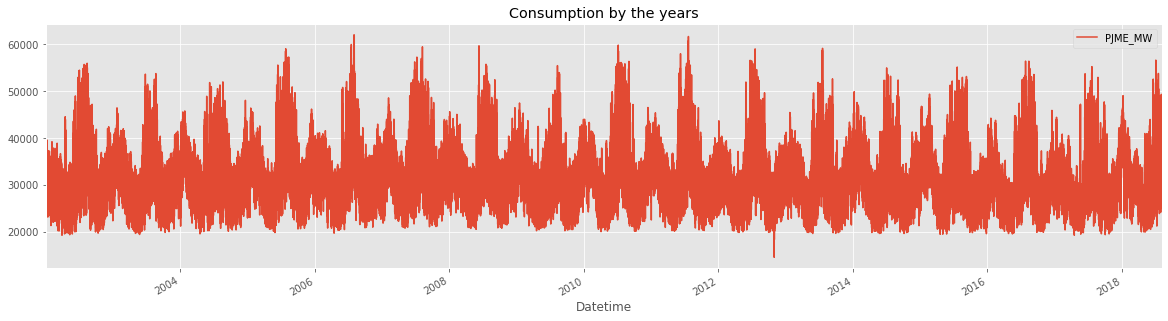

In [11]:
df.plot(figsize=(20,5),legend=True)
plt.title('Consumption by the years')
plt.show()

In [0]:
scaler = sklearn.preprocessing.MinMaxScaler()
df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))

In [0]:
def load_data(stock, seq_len):


    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])

    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #print(X_train)

    X_train = X_train[:110000] 

    y_train = y_train[:110000]

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [97]:
X_train, y_train, X_test, y_test = load_data(df, 20)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)


X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (35346, 20, 1)
y_test.shape =  (35346,)


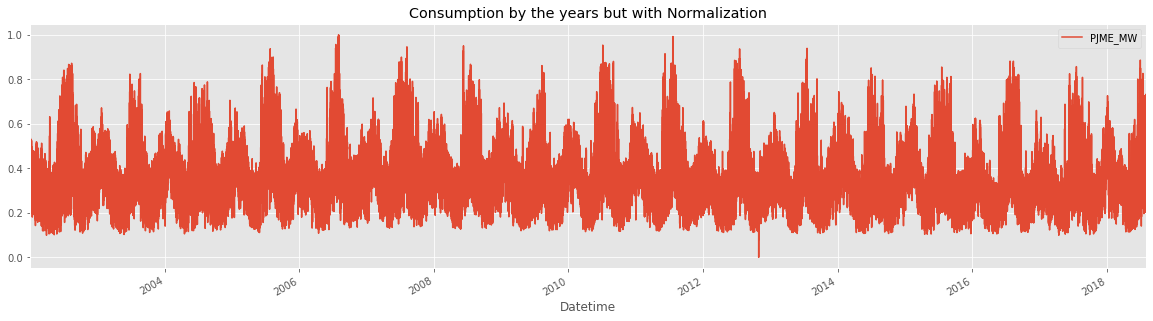

In [15]:
df.plot(figsize=(20,5),legend=True)
plt.title('Consumption by the years but with Normalization')
plt.show()

In [0]:
from keras.layers import GRU

The next few cells build a Simple 3 layer Recurrent Neural Network with 3 Layers and minimal Dropout. Then the layer runs on a 10% validation split with the training set for 10 epochs to show a plot of validation loss vs training loss which is Mean Squared Error, prior to calculation of model predictions against test set via R^2 score and then plotting the whole actual vs predicted comparison.

In [67]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=True))
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(40,activation="relu",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 20, 40)            1680      
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 20, 40)            3240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 40)                3240      
_________________________________________________________________
dropout_18 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [70]:
rnn_model.compile(optimizer="adam",loss="MSE")
history1 = rnn_model.fit(X_train, y_train, validation_split= 0.1, epochs=10, batch_size=512)

Train on 99000 samples, validate on 11000 samples
Epoch 1/10
99000/99000 [==============================] - 10s 96us/step - loss: 8.1358e-04 - val_loss: 9.4701e-04
Epoch 2/10
99000/99000 [==============================] - 8s 78us/step - loss: 7.1787e-04 - val_loss: 0.0011
Epoch 3/10
99000/99000 [==============================] - 8s 78us/step - loss: 6.7855e-04 - val_loss: 0.0010
Epoch 4/10
99000/99000 [==============================] - 8s 78us/step - loss: 6.4872e-04 - val_loss: 0.0011
Epoch 5/10
99000/99000 [==============================] - 8s 77us/step - loss: 6.2116e-04 - val_loss: 8.8472e-04
Epoch 6/10
99000/99000 [==============================] - 8s 77us/step - loss: 6.1408e-04 - val_loss: 8.2821e-04
Epoch 7/10
99000/99000 [==============================] - 8s 78us/step - loss: 6.0619e-04 - val_loss: 7.7934e-04
Epoch 8/10
99000/99000 [==============================] - 8s 77us/step - loss: 5.8536e-04 - val_loss: 6.7407e-04
Epoch 9/10
99000/99000 [==============================] -

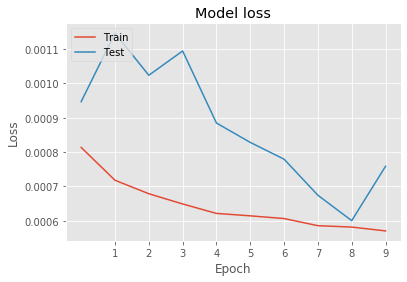

In [72]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(1,10))
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [73]:
rnn_predictions = rnn_model.predict(X_test)
flattened_preds = np.asarray([x for y in rnn_predictions for x in y])
print("R2 Score of RNN model = ",r2_score(y_test,flattened_preds))

R2 Score of RNN model =  0.9604670624515247


In [0]:
def plot_predictions(test, predicted, title, color1, color2):
    plt.figure(figsize=(16,4))
    plt.plot(test, color=color1,label='Actual')
    plt.plot(predicted, alpha=0.7, color=color2,label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption')
    plt.legend()
    plt.show()

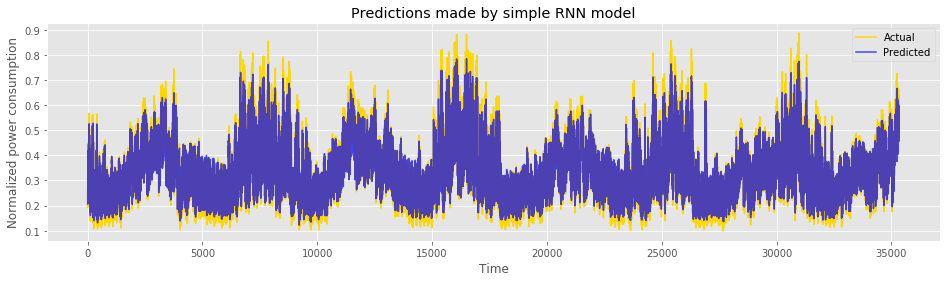

In [75]:
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model","gold","blue")

The next few cells build a 3 layer LSTM Network with 3 Layers and minimal Dropout. Then the layer runs on a 10% validation split with the training set for 10 epochs to show a plot of validation loss vs training loss which is Mean Squared Error, prior to calculation of model predictions against test set via R^2 score and then plotting the whole actual vs predicted comparison.

In [76]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(40,activation="relu",return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(40,activation="relu",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_19 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_20 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_21 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [78]:
lstm_model.compile(optimizer="adam",loss="MSE")
history2 = lstm_model.fit(X_train, y_train, validation_split= 0.1, epochs=10, batch_size=512)

Train on 99000 samples, validate on 11000 samples
Epoch 1/10
99000/99000 [==============================] - 21s 213us/step - loss: 0.0017 - val_loss: 6.8644e-04
Epoch 2/10
99000/99000 [==============================] - 17s 177us/step - loss: 0.0014 - val_loss: 6.1717e-04
Epoch 3/10
99000/99000 [==============================] - 18s 177us/step - loss: 0.0013 - val_loss: 5.0662e-04
Epoch 4/10
99000/99000 [==============================] - 17s 176us/step - loss: 0.0012 - val_loss: 9.1429e-04
Epoch 5/10
99000/99000 [==============================] - 18s 177us/step - loss: 0.0011 - val_loss: 7.3957e-04
Epoch 6/10
99000/99000 [==============================] - 18s 180us/step - loss: 9.8643e-04 - val_loss: 7.2842e-04
Epoch 7/10
99000/99000 [==============================] - 18s 178us/step - loss: 9.3056e-04 - val_loss: 0.0012
Epoch 8/10
99000/99000 [==============================] - 17s 176us/step - loss: 8.8375e-04 - val_loss: 9.9129e-04
Epoch 9/10
99000/99000 [==============================

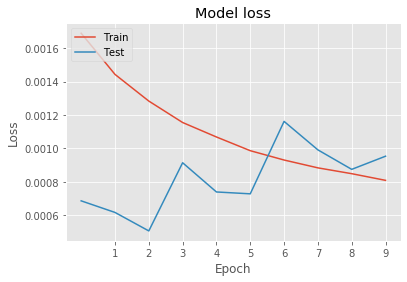

In [80]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(1,10))
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [81]:
#from sklearn.metrics import accuracy_score
lstm_predictions = lstm_model.predict(X_test)
flattened_preds = np.asarray([x for y in lstm_predictions for x in y])
print("R2 Score of LSTM model = ",r2_score(y_test,flattened_preds))



R2 Score of LSTM model =  0.9477873712995023


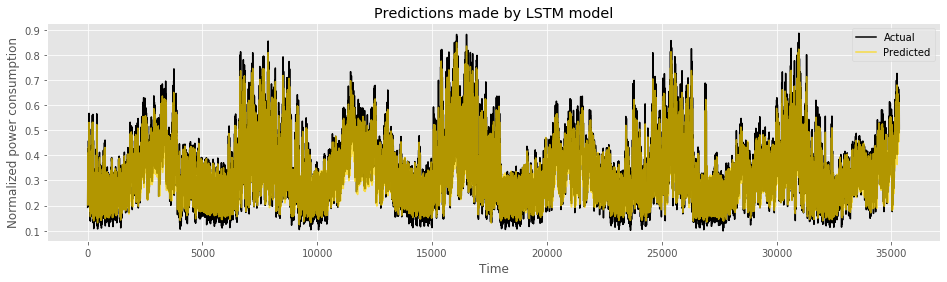

In [82]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model","black","gold")

The next few cells build a 3 layer Gated Recurrent Units Network with 3 Layers and minimal Dropout. Then the layer runs on a 10% validation split with the training set for 10 epochs to show a plot of validation loss vs training loss which is Mean Squared Error, prior to calculation of model predictions against test set via R^2 score and then plotting the whole actual vs predicted comparison.

In [83]:
gru_model = Sequential()

gru_model.add(GRU(40,activation="relu",return_sequences=True, input_shape=(X_train.shape[1],1)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(40,activation="relu",return_sequences=True))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(40,activation="relu",return_sequences=False))
gru_model.add(Dropout(0.15))

gru_model.add(Dense(1))

gru_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 20, 40)            5040      
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 20, 40)            9720      
_________________________________________________________________
dropout_23 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 40)                9720      
_________________________________________________________________
dropout_24 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [84]:
gru_model.compile(optimizer="adam",loss="MSE")
history3 = gru_model.fit(X_train, y_train, validation_split= 0.1, epochs=10, batch_size=512)

Train on 99000 samples, validate on 11000 samples
Epoch 1/10
99000/99000 [==============================] - 19s 190us/step - loss: 0.0196 - val_loss: 0.0046
Epoch 2/10
99000/99000 [==============================] - 15s 151us/step - loss: 0.0045 - val_loss: 0.0014
Epoch 3/10
99000/99000 [==============================] - 15s 153us/step - loss: 0.0030 - val_loss: 9.2154e-04
Epoch 4/10
99000/99000 [==============================] - 15s 151us/step - loss: 0.0025 - val_loss: 9.5082e-04
Epoch 5/10
99000/99000 [==============================] - 15s 152us/step - loss: 0.0022 - val_loss: 9.3377e-04
Epoch 6/10
99000/99000 [==============================] - 15s 154us/step - loss: 0.0019 - val_loss: 8.3729e-04
Epoch 7/10
99000/99000 [==============================] - 15s 151us/step - loss: 0.0017 - val_loss: 5.9382e-04
Epoch 8/10
99000/99000 [==============================] - 15s 150us/step - loss: 0.0015 - val_loss: 9.7888e-04
Epoch 9/10
99000/99000 [==============================] - 15s 151us/st

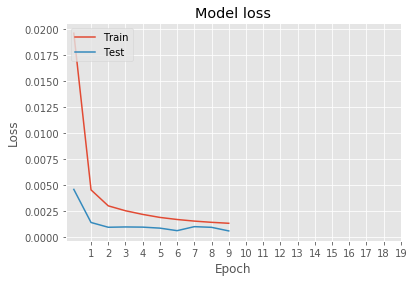

In [85]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(1,20))
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [86]:
gru_predictions = gru_model.predict(X_test)
flattened_preds = np.asarray([x for y in gru_predictions for x in y])
print("R2 Score of GRU model = ",r2_score(y_test,flattened_preds))

R2 Score of GRU model =  0.9680719563058777


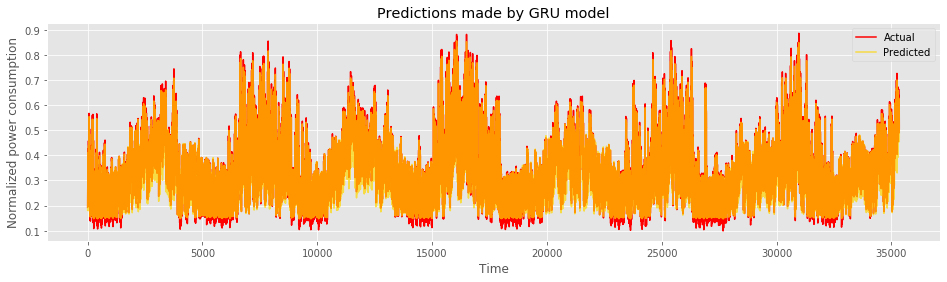

In [87]:
plot_predictions(y_test, gru_predictions, "Predictions made by GRU model","red","gold")

The above notebook not only builds the dataset and analyzes it, but also models 3 different kinds of network on the temporal data under similar extenuous circumstances. The GRU network here gives us the best results, but if the epochs were extended till all three networks started overfitting, the LSTM does have the propensity to have the better results when that happens. This was fun, next on the class project!!